# Final Capstone - Using Deep Learning to identify pneumonia in chest x-rays

by Benjamin Thanyawatpokin

For this final capstone, I have decided to pursue a deeper knowledge of computer vision. This is mainly because I can see a lot of application in using computer vision to help with medicine and patient diagnosis-related data science issues. In addition to that, personally I have also wanted to work using Data Science to help the medical field in some capacity.

This set is also very relevant to the current pandemic as one of the most common symptoms of COVID-19 is to develop pneumonia in the lungs. Physicians and radiologists around the world spend quite a lot of their work days looking over x-rays of patients to determine whether or not they have an affliction. If there were a machine learning algorithm to help them identify pneumonia, it would seriously decrease the workload and give them more time to see patients.

The dataset used in this capstone can be found at Kaggle at:

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

More information about the dataset:

- The dataset is comprised of x-ray chest scans in people who were tested for pneumonia. The images are divided into people with pnemonia in their lungs and those with normal, non-pneumonia lungs. There were no x-rays with patients with other lung afflictions. Thus, there was no possibilty of noise in the dataset originating from lungs in other states.
- Pixel data has already been regularized between 0 and 1, so there is no need to divide the pixel intensity data by 255 as most other computer vision projects.
- Included with the download was a training, test, and validation dataset, so no train_test split was required
- However, the validation dataset only included 16 images in total (8 non-pneumonia and 8 pneumonia), which led to somewhat strange results when checking against validation accuracy on deep learning models.
- Images were resized to 150x150 pixel size during data preprocessing (which is smaller than other models such as VGG16/19 which use 224x224 size images)

## Step 1: Library Loading

In [29]:
#general libraries/linear algebra
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import random
import cv2
import seaborn as sns
import scipy
from tqdm import tqdm

#tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

#sklearn
import skimage
from sklearn import model_selection
from sklearn.model_selection import train_test_split, learning_curve,KFold,cross_val_score,StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score
from skimage.transform import resize

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

## Step 2: Data Loading

The below function:
1. looks through the specified directory 
2. assigns a label to the data (0 for normal, 1 for pneumonia patients) 
3. appends the pixel data to an array
4. resizes the data to make it 150x150 pixels
5. changes the resulting array to a float32

In [30]:
#libraries that I forgot to import above which pertain to data processing
from tqdm import tqdm
import skimage
from skimage.transform import resize

def load_data(folder):
    #Initialize array for all the image data to go into
    X = []
    y = []
    
    print("Loading {}".format(folder))
    
    #Loops through all the folders in the directory
    for folder_name in os.listdir(folder):
        
        #Need to skip over .dsstore folders
        if not folder_name.startswith('.'):
            
            #This is where I put labels onto the data.
            if folder_name in ['NORMAL']:
                label = 0
            elif folder_name in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            
            #loop through every file
            for img_filename in tqdm(os.listdir(folder + folder_name)):
                
                #img_path comes from the fed-in folder dir, then the folder name in the folder dir, then the file name
                img_path = cv2.imread(folder + folder_name + '/' + img_filename)
                
                #Some images have strange path names, loop over them
                if img_path is not None:
                    
                    #resize to 150x150
                    image = skimage.transform.resize(img_path, (150, 150, 3))

                    #Append to the arrays initialized before
                    X.append(image)
                    y.append(label)
    
    #convert arrays to floats or ints
    X = np.array(X, dtype = 'float32')
    y = np.array(y, dtype = 'int32')
    
    return(X, y)

There are three datasets which we need to load:
1. Training set
2. Test set
3. Validation set

The validation set will be used in our CNN model to help validate the results.

In [31]:
train_images, train_labels = load_data('/Users/ben/Documents/Thinkful/chest_xray/chest_xray/train/')

  0%|          | 2/3876 [00:00<05:07, 12.61it/s]

Loading /Users/ben/Documents/Thinkful/chest_xray/chest_xray/train/


100%|██████████| 1342/1342 [07:52<00:00,  2.84it/s]


In [32]:
test_images, test_labels = load_data('/Users/ben/Documents/Thinkful/chest_xray/chest_xray/test/')

  1%|          | 2/390 [00:00<00:33, 11.67it/s]

Loading /Users/ben/Documents/Thinkful/chest_xray/chest_xray/test/


100%|██████████| 234/234 [01:36<00:00,  2.42it/s]


In [33]:
val_images, val_labels = load_data('/Users/ben/Documents/Thinkful/chest_xray/chest_xray/val/')

 22%|██▏       | 2/9 [00:00<00:00, 14.34it/s]

Loading /Users/ben/Documents/Thinkful/chest_xray/chest_xray/val/


100%|██████████| 9/9 [00:01<00:00,  4.78it/s]


Let's check the shape of the three classes we will be using

In [34]:
print(train_images.shape)
print(test_images.shape)
print(val_images.shape)

(5216, 150, 150, 3)
(624, 150, 150, 3)
(16, 150, 150, 3)


### Data Visualization

In this short section, I will do short visualization of the data I have.

The section will include:
1. Data counts for pneumonia and non-pneumonia x-rays for each set
2. Visualizations for each of those counts
3. Example images of pneumonia and non-pneumonia x-rays (from the training set)
4. Pixel intensity data for the images in #3.

In [103]:
print("The number of training set pneumonia x-rays: {}.".format(np.count_nonzero(train_labels == 1)))
print("The number of training set non-pneumonia x-rays: {}.".format(np.count_nonzero(train_labels == 0)))

The number of training set pneumonia x-rays: 3875.
The number of training set non-pneumonia x-rays: 1341.


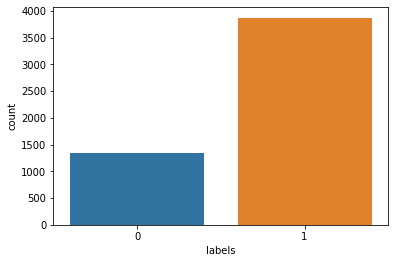

In [8]:
#create a dataframe and then run a visualization through it
check = pd.DataFrame()
check['labels'] = train_labels
labs = check['labels']

sns.countplot(labs)

In [104]:
print("The number of test set pneumonia x-rays: {}.".format(np.count_nonzero(test_labels == 1)))
print("The number of test set non-pneumonia x-rays: {}.".format(np.count_nonzero(test_labels == 0)))

The number of test set pneumonia x-rays: 390.
The number of test set non-pneumonia x-rays: 234.


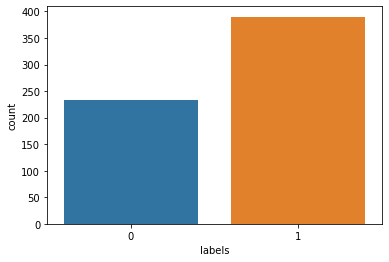

In [9]:
test_check = pd.DataFrame()
test_check['labels'] = test_labels
check = test_check['labels']

sns.countplot(check)

In [105]:
print("The number of test set pneumonia x-rays: {}.".format(np.count_nonzero(val_labels == 1)))
print("The number of test set non-pneumonia x-rays: {}.".format(np.count_nonzero(val_labels == 0)))

The number of test set pneumonia x-rays: 8.
The number of test set non-pneumonia x-rays: 8.


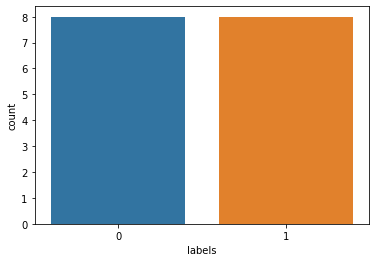

In [10]:
val_check = pd.DataFrame()
val_check['labels'] = val_labels
check = val_check['labels']

sns.countplot(check)

<function matplotlib.pyplot.show(*args, **kw)>

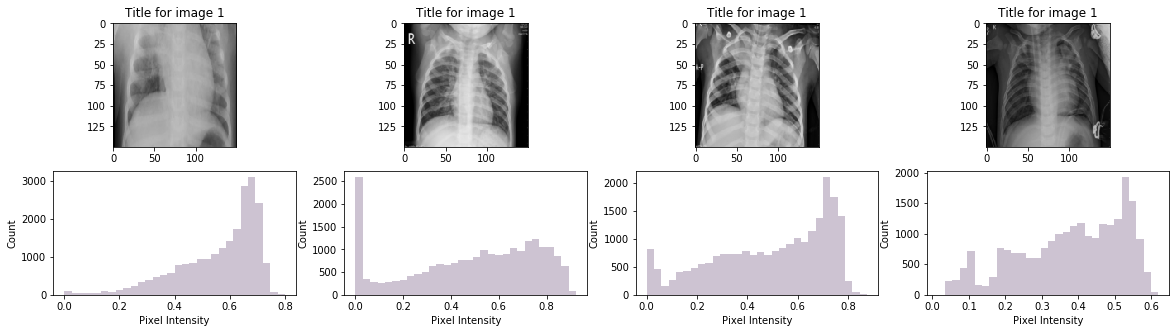

In [11]:
#PNEUMONIA training set images only

a = train_images[123]

plt.figure(figsize=(20,5))

plt.subplot(241)
plt.imshow(train_images[123], cmap='gray')
plt.title('Title for image {}'.format(train_labels[123]))

plt.subplot(242)
plt.imshow(train_images[124], cmap='gray')
plt.title('Title for image {}'.format(train_labels[124]))

plt.subplot(243)
plt.imshow(train_images[125], cmap='gray')
plt.title('Title for image {}'.format(train_labels[125]))

plt.subplot(244)
plt.imshow(train_images[136], cmap='gray')
plt.title('Title for image {}'.format(train_labels[136]))

plt.subplot(245)
#Take only the pixel data from one color each (corresponds to red, green, then blue.)
plt.hist(train_images[123][:,:,0].flatten(), bins = 30, color='r', alpha = 0.1)
plt.hist(train_images[123][:,:,1].flatten(), bins = 30, color='g', alpha = 0.1)
plt.hist(train_images[123][:,:,2].flatten(), bins = 30, color='b', alpha = 0.1)
plt.ylabel('Count')
plt.xlabel('Pixel Intensity')

plt.subplot(246)
plt.hist(train_images[124][:,:,0].flatten(), bins = 30, color='r', alpha = 0.1)
plt.hist(train_images[124][:,:,1].flatten(), bins = 30, color='g', alpha = 0.1)
plt.hist(train_images[124][:,:,2].flatten(), bins = 30, color='b', alpha = 0.1)
plt.ylabel('Count')
plt.xlabel('Pixel Intensity')

plt.subplot(247)
plt.hist(train_images[125][:,:,0].flatten(), bins = 30, color='r', alpha = 0.1)
plt.hist(train_images[125][:,:,1].flatten(), bins = 30, color='g', alpha = 0.1)
plt.hist(train_images[125][:,:,2].flatten(), bins = 30, color='b', alpha = 0.1)
plt.ylabel('Count')
plt.xlabel('Pixel Intensity')

plt.subplot(248)
plt.hist(train_images[126][:,:,0].flatten(), bins = 30, color='r', alpha = 0.1)
plt.hist(train_images[126][:,:,1].flatten(), bins = 30, color='g', alpha = 0.1)
plt.hist(train_images[126][:,:,2].flatten(), bins = 30, color='b', alpha = 0.1)
plt.ylabel('Count')
plt.xlabel('Pixel Intensity')

plt.show

<function matplotlib.pyplot.show(*args, **kw)>

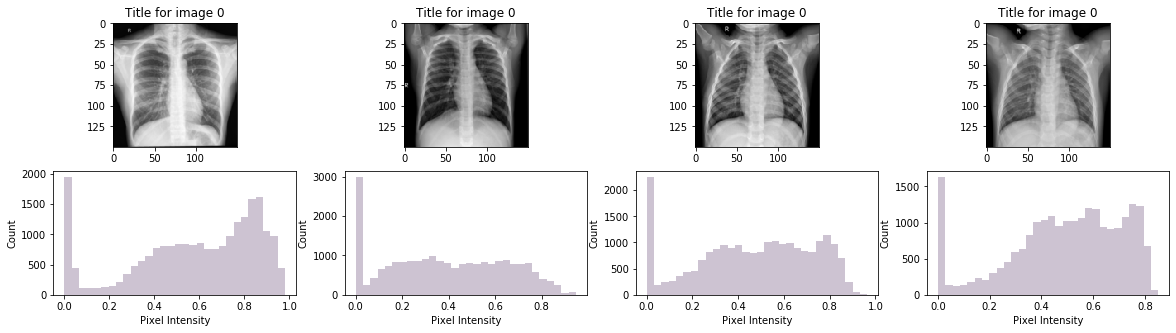

In [12]:
#NORMAL images only

plt.figure(figsize=(20,5))

plt.subplot(241)
plt.imshow(train_images[4010], cmap='gray')
plt.title('Title for image {}'.format(train_labels[4010]))

plt.subplot(242)
plt.imshow(train_images[4011], cmap='gray')
plt.title('Title for image {}'.format(train_labels[4011]))

plt.subplot(243)
plt.imshow(train_images[4012], cmap='gray')
plt.title('Title for image {}'.format(train_labels[4012]))

plt.subplot(244)
plt.imshow(train_images[4013], cmap='gray')
plt.title('Title for image {}'.format(train_labels[4013]))

plt.subplot(245)
#Take only the pixel data from one color each (corresponds to red, green, then blue.)
plt.hist(train_images[4010][:,:,0].flatten(), bins = 30, color='r', alpha = 0.1)
plt.hist(train_images[4010][:,:,1].flatten(), bins = 30, color='g', alpha = 0.1)
plt.hist(train_images[4010][:,:,2].flatten(), bins = 30, color='b', alpha = 0.1)
plt.ylabel('Count')
plt.xlabel('Pixel Intensity')

plt.subplot(246)
plt.hist(train_images[4011][:,:,0].flatten(), bins = 30, color='r', alpha = 0.1)
plt.hist(train_images[4011][:,:,1].flatten(), bins = 30, color='g', alpha = 0.1)
plt.hist(train_images[4011][:,:,2].flatten(), bins = 30, color='b', alpha = 0.1)
plt.ylabel('Count')
plt.xlabel('Pixel Intensity')

plt.subplot(247)
plt.hist(train_images[4012][:,:,0].flatten(), bins = 30, color='r', alpha = 0.1)
plt.hist(train_images[4012][:,:,1].flatten(), bins = 30, color='g', alpha = 0.1)
plt.hist(train_images[4012][:,:,2].flatten(), bins = 30, color='b', alpha = 0.1)
plt.ylabel('Count')
plt.xlabel('Pixel Intensity')

plt.subplot(248)
plt.hist(train_images[4013][:,:,0].flatten(), bins = 30, color='r', alpha = 0.1)
plt.hist(train_images[4013][:,:,1].flatten(), bins = 30, color='g', alpha = 0.1)
plt.hist(train_images[4013][:,:,2].flatten(), bins = 30, color='b', alpha = 0.1)
plt.ylabel('Count')
plt.xlabel('Pixel Intensity')
plt.show

From the above pixel intensity data, it can probably be surmised that there are certain differences between the pneumonia and non-pneumonia patients. Histograms of pixel intensity show taller peaks in the pneumonia, most likely from the "spots" present in the x-ray of lungs.

Below, I did a quick kruskal-wallis A/B test in order to see if pixel values really were different between the two sets of data. I only took this from the training set as I believed it would be a good representative sample.

In [13]:
from scipy import stats

#A/B test of all pneumonia images (train up until #3875) and non-pneumon (everything after 3785).
#Also, flatten to get a 1D array to compare.
print(stats.kruskal(train_images[:3875][:,:,0].flatten(), train_images[3785:][:,:,0].flatten().shape))
print(stats.kruskal(train_images[:3875][:,:,1].flatten(), train_images[3785:][:,:,1].flatten().shape))
print(stats.kruskal(train_images[:3875][:,:,2].flatten(), train_images[3785:][:,:,2].flatten().shape))

KruskalResult(statistic=3.0503259852948004, pvalue=0.08072093928365541)
KruskalResult(statistic=3.0607361897407457, pvalue=0.08020532279785404)
KruskalResult(statistic=3.057320370546338, pvalue=0.08037411553184338)


According to the p-values, there is no real statistical significance, though it does come mildly close. Since there is not too big of a gap between pneumonia and non-pneumonia patients, this may translate into slight performance hits in analysis, but we shall see below.

### Data reshaping and to_categorical

For this dataset, the RGB pixel values were already regularized between 1 and 0. Thus, I do not need to divide each set by 255 as is usually done in most traditional computer vision data sets.

However, there is some reshaping that I will do to use in some of the analysis I will conduct further below.

In addition, to feed the data into ANN, I will need to run a to_categorical function on the label data.

In [106]:
reshape_train_images = train_images.reshape(5216, 67500)
reshape_test_images = test_images.reshape(624, 67500)

cat_train_labels = to_categorical(train_labels, 2)
cat_test_labels = to_categorical(test_labels, 2)

## First analysis : Logistic Regression

Before jumping into deep learning, I want run the data through a more basic model. The reason for this is because there is always the possibility that the data at hand doesn't need the most sophisticated methods to pull good results out of it.

If good results can be pulled with minimal computational effort, the solution could probably be more widely applied and be easier to run on a multitude of systems.

I am going to use the re-shaped train and test images here.

First, I will train the most basic LogisticRegression model I can think of.

In [18]:
from sklearn.linear_model import LogisticRegression

#LogisticRegression with most basic hyperparameters (l2 penalty)
lr = LogisticRegression(solver = 'lbfgs', max_iter = 10000)
lr.fit(reshape_train_images, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [19]:
print("Training set Accuracy for logistic regression classifier = ", lr.score(reshape_train_images, train_labels) )
print("Test set Accuracy for logistic regression classifier = ", lr.score(reshape_test_images, test_labels) )
print("")

from sklearn import metrics

print('Training set classification report')
lr_pred_train = lr.predict(reshape_train_images)
print(metrics.classification_report(train_labels, lr_pred_train))

print('------------')

print('Test set classification report')
lr_pred_test = lr.predict(reshape_test_images)
print(metrics.classification_report(test_labels, lr_pred_test))

Training set Accuracy for logistic regression classifier =  1.0
Test set Accuracy for logistic regression classifier =  0.7467948717948718

Training set classification report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1341
           1       1.00      1.00      1.00      3875

    accuracy                           1.00      5216
   macro avg       1.00      1.00      1.00      5216
weighted avg       1.00      1.00      1.00      5216

------------
Test set classification report
              precision    recall  f1-score   support

           0       0.93      0.35      0.51       234
           1       0.72      0.98      0.83       390

    accuracy                           0.75       624
   macro avg       0.82      0.67      0.67       624
weighted avg       0.80      0.75      0.71       624



Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


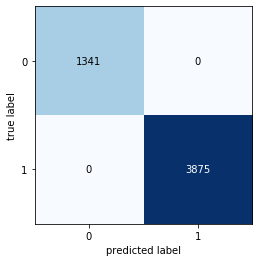

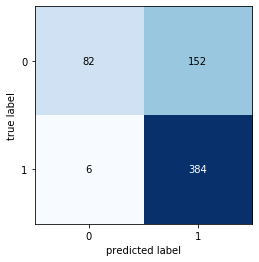

In [20]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

lr_cnf = confusion_matrix(train_labels, lr_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = lr_cnf)

lr_cnf = confusion_matrix(test_labels, lr_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = lr_cnf)

75% on the most basic model is promising. However, there is considerable overfitting happening here.

I will take this a little further to see what I can get. However, I don't want the focus to be entirely on logistic regression, so I will only push this so far.

In [107]:
from sklearn.linear_model import LogisticRegression

#Change to L1 penalty and liblinear solver. Max_iter not changed.
lr = LogisticRegression(penalty = 'l1', solver = 'liblinear', max_iter = 10000)
lr.fit(reshape_train_images, train_labels)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [108]:
print("Training set Accuracy for logistic regression classifier = ", lr.score(reshape_train_images, train_labels) )
print("Test set Accuracy for logistic regression classifier = ", lr.score(reshape_test_images, test_labels) )
print("")

from sklearn import metrics

print('Training set classification report')
lr_pred_train = lr.predict(reshape_train_images)
print(metrics.classification_report(train_labels, lr_pred_train))

print('------------')

print('Test set classification report')
lr_pred_test = lr.predict(reshape_test_images)
print(metrics.classification_report(test_labels, lr_pred_test))

Training set Accuracy for logistic regression classifier =  0.9881134969325154
Test set Accuracy for logistic regression classifier =  0.7451923076923077

Training set classification report
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1341
           1       0.99      0.99      0.99      3875

    accuracy                           0.99      5216
   macro avg       0.99      0.98      0.98      5216
weighted avg       0.99      0.99      0.99      5216

------------
Test set classification report
              precision    recall  f1-score   support

           0       0.94      0.34      0.50       234
           1       0.71      0.99      0.83       390

    accuracy                           0.75       624
   macro avg       0.83      0.66      0.67       624
weighted avg       0.80      0.75      0.71       624



Training set Confusion Matrix
-----------------------------
Test set Confusion Matrix


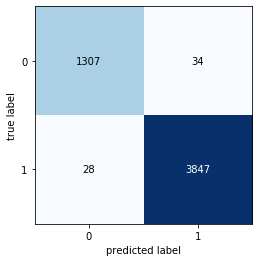

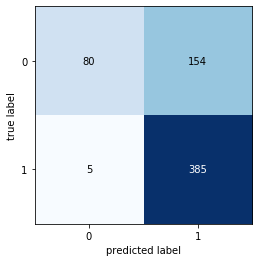

In [110]:
from mlxtend.evaluate import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

print('Training set Confusion Matrix')
print("-----------------------------")
print('Test set Confusion Matrix')

lr_cnf = confusion_matrix(train_labels, lr_pred_train)
fig, ax = plot_confusion_matrix(conf_mat = lr_cnf)

lr_cnf = confusion_matrix(test_labels, lr_pred_test)
fig, ax = plot_confusion_matrix(conf_mat = lr_cnf)

There is significant overfitting occuring (again).

The accuracy score also did not change at all when changing to l1 penalty.

As I said above, I'm not going to linger here for too long so I will leave it at this for now.

The below code is only to show what I would do if I were serious about finding the most optimal logistic regression hyperparameters. 

I attempted to run this on my own, however it did not finish after one full day of computing. For fear of my computer, I decided to leave it be. 

In [ ]:
from sklearn.model_selection import GridSearchCV

lr_params = {"penalty": ['l1', 'l2'], "solver": ['lbfgs', 'liblinear'], "C": np.logspace(-1,1,10), "max_iter": [1000, 5000, 10000]}
lr = LogisticRegression()
lr_op = GridSearchCV(lr, lr_params, cv = 3)

lr_op.fit(reshape_train_images, train_labels)

print('Accuracy for Logistic Regression Classifier Grids: {}',format(lr_op.cv_results_))

print('Best Params: ', lr_op.best_params_)

print('Best GridsearchCV training accuracy: ', lr_op.best_score_)

## ANN

In this section, I will be using ANN to analyze the dataset.

I will start with a basic model and gradually make it more complex.

The first model characteristics:

- 3 Dense layers
- relu activation
- sgd optimizer
- batch size = 128
- epochs = 10

In [26]:
model = Sequential()

model.add(Dense(128, input_shape=(67500,), activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics=['accuracy'])

model.fit(reshape_train_images, cat_train_labels, batch_size = 128, epochs = 10, verbose = 1)

Epoch 1/10
41/41 [==============================] - 2s 43ms/step - loss: 0.7863 - accuracy: 0.7191
Epoch 2/10
41/41 [==============================] - 1s 34ms/step - loss: 0.4865 - accuracy: 0.7826
Epoch 3/10
41/41 [==============================] - 1s 35ms/step - loss: 0.4408 - accuracy: 0.8150
Epoch 4/10
41/41 [==============================] - 1s 33ms/step - loss: 0.4009 - accuracy: 0.8572
Epoch 5/10
41/41 [==============================] - 1s 33ms/step - loss: 0.3761 - accuracy: 0.8464
Epoch 6/10
41/41 [==============================] - 1s 33ms/step - loss: 0.3512 - accuracy: 0.8622
Epoch 7/10
41/41 [==============================] - 1s 32ms/step - loss: 0.2814 - accuracy: 0.8909
Epoch 8/10
41/41 [==============================] - 1s 33ms/step - loss: 0.2942 - accuracy: 0.8854
Epoch 9/10
41/41 [==============================] - 1s 33ms/step - loss: 0.2637 - accuracy: 0.8961
Epoch 10/10
41/41 [==============================] - 1s 34ms/step - loss: 0.2523 - accuracy: 0.9018


In [27]:
score = model.evaluate(reshape_test_images, cat_test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

Test Score: 1.1467691659927368
Test Accuracy: 0.6442307829856873


In [28]:
predictions = model.predict_classes(reshape_test_images)
predictions = predictions.reshape(1, -1)[0]

In [29]:
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))

              precision    recall  f1-score   support

   Normal: 0       1.00      0.05      0.10       234
Pneumonia: 1       0.64      1.00      0.78       390

    accuracy                           0.64       624
   macro avg       0.82      0.53      0.44       624
weighted avg       0.77      0.64      0.52       624



In [30]:
cm = confusion_matrix(test_labels, predictions)
print(cm)

[[ 12 222]
 [  0 390]]


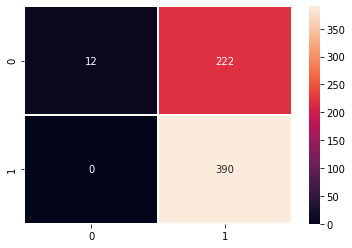

In [31]:
sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

The model appears to be overfitting with a training accuracy score of 90% and test accuracy of 65%. This performance is middling and I believe I can do better than this.

The second model characteristics:

- 4 Dense layers
- relu activation (softmax for the final layer)
- sgd optimizer
- batch size = 64
- epochs = 20

In [32]:
model = Sequential()

model.add(Dense(128, input_shape=(67500,), activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(optimizer = 'sgd', loss = 'categorical_crossentropy', metrics=['accuracy'])

model.fit(reshape_train_images, cat_train_labels, batch_size = 64, epochs = 20, verbose = 1)

Epoch 1/20
82/82 [==============================] - 3s 36ms/step - loss: 0.6122 - accuracy: 0.7199
Epoch 2/20
82/82 [==============================] - 2s 22ms/step - loss: 0.4794 - accuracy: 0.7862
Epoch 3/20
82/82 [==============================] - 2s 21ms/step - loss: 0.3992 - accuracy: 0.8403
Epoch 4/20
82/82 [==============================] - 2s 21ms/step - loss: 0.3532 - accuracy: 0.8554
Epoch 5/20
82/82 [==============================] - 2s 21ms/step - loss: 0.2811 - accuracy: 0.8854
Epoch 6/20
82/82 [==============================] - 2s 22ms/step - loss: 0.2300 - accuracy: 0.9091
Epoch 7/20
82/82 [==============================] - 2s 20ms/step - loss: 0.2448 - accuracy: 0.9018
Epoch 8/20
82/82 [==============================] - 2s 20ms/step - loss: 0.1894 - accuracy: 0.9243
Epoch 9/20
82/82 [==============================] - 2s 21ms/step - loss: 0.1838 - accuracy: 0.9287
Epoch 10/20
82/82 [==============================] - 2s 21ms/step - loss: 0.1563 - accuracy: 0.9369
Epoch 11/

In [33]:
score = model.evaluate(reshape_test_images, cat_test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

Test Score: 0.9138106107711792
Test Accuracy: 0.7387820482254028


In [34]:
predictions = model.predict_classes(reshape_test_images)
predictions = predictions.reshape(1, -1)[0]

print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))

              precision    recall  f1-score   support

   Normal: 0       0.94      0.32      0.48       234
Pneumonia: 1       0.71      0.99      0.83       390

    accuracy                           0.74       624
   macro avg       0.82      0.66      0.65       624
weighted avg       0.79      0.74      0.70       624



[[ 76 158]
 [  5 385]]


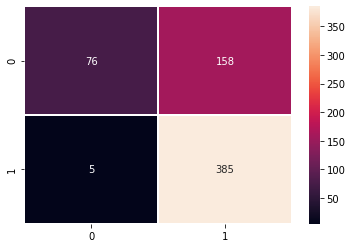

In [35]:
cm = confusion_matrix(test_labels, predictions)
print(cm)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

Much better this time around with 75% test accuracy. However, overfitting is still present with a training accuracy of 95%. I believe this may be getting a little worse.

The third model characteristics:

- 4 Dense layers
- relu activation (softmax for the final layer)
- sgd optimizer
- batch size = 64
- epochs = 30
- learning rate changed to 0.001

In [36]:
from tensorflow.keras import optimizers

model = Sequential()

model.add(Dense(128, input_shape=(67500,), activation='relu'))

model.add(Dense(64, activation='relu'))

model.add(Dense(32, activation='relu'))

model.add(Dense(2, activation='softmax'))

model.compile(optimizers.SGD(lr=0.001), loss = 'categorical_crossentropy', metrics=['accuracy'])

model.fit(reshape_train_images, cat_train_labels, batch_size = 64, epochs = 30, verbose = 1)

Epoch 1/30
82/82 [==============================] - 6s 71ms/step - loss: 0.5339 - accuracy: 0.7446
Epoch 2/30
82/82 [==============================] - 4s 52ms/step - loss: 0.3767 - accuracy: 0.8476
Epoch 3/30
82/82 [==============================] - 2s 26ms/step - loss: 0.2941 - accuracy: 0.8827
Epoch 4/30
82/82 [==============================] - 2s 25ms/step - loss: 0.2659 - accuracy: 0.8963
Epoch 5/30
82/82 [==============================] - 2s 24ms/step - loss: 0.2265 - accuracy: 0.9160
Epoch 6/30
82/82 [==============================] - 2s 23ms/step - loss: 0.2055 - accuracy: 0.9214
Epoch 7/30
82/82 [==============================] - 2s 25ms/step - loss: 0.1803 - accuracy: 0.9350
Epoch 8/30
82/82 [==============================] - 3s 31ms/step - loss: 0.1742 - accuracy: 0.9337
Epoch 9/30
82/82 [==============================] - 2s 29ms/step - loss: 0.1649 - accuracy: 0.9398
Epoch 10/30
82/82 [==============================] - 2s 25ms/step - loss: 0.1602 - accuracy: 0.9387
Epoch 11/

In [37]:
score = model.evaluate(reshape_test_images, cat_test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

Test Score: 0.4909607768058777
Test Accuracy: 0.8044871687889099


In [38]:
predictions = model.predict_classes(reshape_test_images)
predictions = predictions.reshape(1, -1)[0]

print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))

              precision    recall  f1-score   support

   Normal: 0       0.88      0.56      0.68       234
Pneumonia: 1       0.78      0.95      0.86       390

    accuracy                           0.80       624
   macro avg       0.83      0.75      0.77       624
weighted avg       0.82      0.80      0.79       624



[[130 104]
 [ 18 372]]


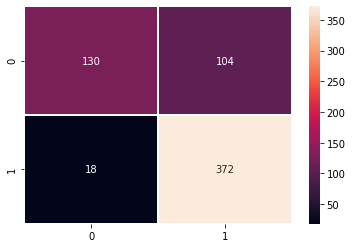

In [39]:
cm = confusion_matrix(test_labels, predictions)
print(cm)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

Even better this time with a train/test accuracy split of 95% to 80%. However, there is still overfitting.

The fourth model characteristics:

- 4 Dense layers
- relu activation (softmax for the final layer)
- sgd optimizer
- batch size = 64
- epochs = 30
- learning rate changed to 0.0001
- validation split of 0.2 inserted for better verification of results

In [111]:
from tensorflow.keras import datasets, layers, models

model = models.Sequential()

model.add(layers.Dense(128, input_shape=(67500,), activation='relu'))

model.add(layers.Dense(64, activation='relu'))

model.add(layers.Dense(32, activation='relu'))

model.add(layers.Dense(2, activation='softmax'))

model.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_66 (Dense)             (None, 128)               8640128   
_________________________________________________________________
dense_67 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_68 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_69 (Dense)             (None, 2)                 66        
Total params: 8,650,530
Trainable params: 8,650,530
Non-trainable params: 0
_________________________________________________________________


In [113]:
from tensorflow.keras import optimizers

model.compile(optimizers.SGD(lr=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

history = model.fit(reshape_train_images, cat_train_labels, batch_size = 64, epochs = 30, verbose = 1, validation_split= 0.2)

Epoch 1/30
66/66 [==============================] - 3s 42ms/step - loss: 0.2988 - accuracy: 0.9087 - val_loss: 2.4963 - val_accuracy: 0.0000e+00
Epoch 2/30
66/66 [==============================] - 2s 25ms/step - loss: 0.2508 - accuracy: 0.9288 - val_loss: 2.4153 - val_accuracy: 0.0000e+00
Epoch 3/30
66/66 [==============================] - 2s 25ms/step - loss: 0.2445 - accuracy: 0.9288 - val_loss: 2.1852 - val_accuracy: 0.0000e+00
Epoch 4/30
66/66 [==============================] - 2s 23ms/step - loss: 0.2370 - accuracy: 0.9288 - val_loss: 2.3365 - val_accuracy: 0.0000e+00
Epoch 5/30
66/66 [==============================] - 2s 23ms/step - loss: 0.2295 - accuracy: 0.9288 - val_loss: 2.0203 - val_accuracy: 0.0000e+00
Epoch 6/30
66/66 [==============================] - 2s 23ms/step - loss: 0.2237 - accuracy: 0.9288 - val_loss: 2.3364 - val_accuracy: 0.0000e+00
Epoch 7/30
66/66 [==============================] - 2s 23ms/step - loss: 0.2174 - accuracy: 0.9288 - val_loss: 2.2159 - val_accura

In [114]:
score = model.evaluate(reshape_test_images, cat_test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

Test Score: 0.7363380193710327
Test Accuracy: 0.6362179517745972


In [115]:
predictions = model.predict_classes(reshape_test_images)
predictions = predictions.reshape(1, -1)[0]

print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))

              precision    recall  f1-score   support

   Normal: 0       1.00      0.03      0.06       234
Pneumonia: 1       0.63      1.00      0.77       390

    accuracy                           0.64       624
   macro avg       0.82      0.51      0.42       624
weighted avg       0.77      0.64      0.51       624



[[  7 227]
 [  0 390]]


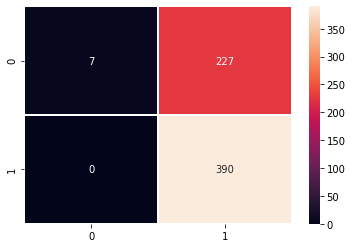

In [116]:
cm = confusion_matrix(test_labels, predictions)
print(cm)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

Below is a plot of accuracy and validation set accuracy over time

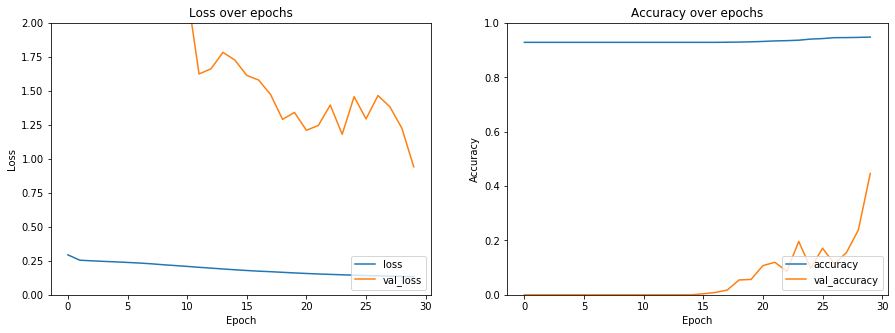

In [46]:
plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(loc='lower right')
plt.title("Loss over epochs")

plt.subplot(122)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.show()

From the above graphs, it seems that more epochs may be needed as accuracy and loss seem to be on their way to converging.

Interestingly enough, test set accuracy scores actually seem to be doing worse than before with 65% or so.

Actually, at this point I want to focus on the main skill I will be showcasing here which is using CNN.

## The main method of analysis: CNN

In this section, I'm going to show my work with CNN, going from the most basic textbook models to a much more involved model.

I will show you the point where my models became too complex and thus actually hindered performance, and how I pulled it back to regain some performance.

I have many different trained models on display here, I will be annotating each with brief notes, so please look to them if you want to avoid looking at the minutae of each model.


Some notes for commonalities between all models:

- Filter size is always the same (3,3)
- Activation is always relu
- Padding is always set to "same" so zero padding can be utilized where necessary
- MaxPooling size is always (2,2)
- Compile hyperparameters never change (optimizer = adam, loss = sparse_categorical_crossentropy, metrics = accuracy). I thought about changing to binary_categorical_crossentropy, however I thought that could be left for "further research"

#### Model 1:
Most basic model.

- 2 convolution layers with 32 filters each. Maxpooling ONLY after each
- 2 Dense layers
- batch size of 128
- 20 epochs
- validation split of 0.2

In [35]:
model = models.Sequential()

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation = 'relu', padding='same', input_shape = [150,150,3]),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(32, (3,3), activation = 'relu', padding='same'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 75, 75, 32)        9248      
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 43808)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               5607552   
_________________________________________________________________
dense_11 (Dense)             (None, 2)                

In [36]:
model.compile(optimizer='adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

In [37]:
model.fit(train_images, train_labels, batch_size = 128, epochs = 20, verbose = 1, validation_split = 0.2)

Epoch 1/20
33/33 [==============================] - 31s 929ms/step - loss: 0.3483 - accuracy: 0.9104 - val_loss: 1.9787 - val_accuracy: 0.0000e+00
Epoch 2/20
33/33 [==============================] - 32s 981ms/step - loss: 0.1552 - accuracy: 0.9432 - val_loss: 1.0770 - val_accuracy: 0.5307
Epoch 3/20
33/33 [==============================] - 35s 1s/step - loss: 0.0670 - accuracy: 0.9744 - val_loss: 0.3230 - val_accuracy: 0.8860
Epoch 4/20
33/33 [==============================] - 32s 968ms/step - loss: 0.0477 - accuracy: 0.9830 - val_loss: 0.1865 - val_accuracy: 0.9358
Epoch 5/20
33/33 [==============================] - 32s 955ms/step - loss: 0.0478 - accuracy: 0.9820 - val_loss: 0.6278 - val_accuracy: 0.7720
Epoch 6/20
33/33 [==============================] - 31s 934ms/step - loss: 0.0290 - accuracy: 0.9897 - val_loss: 0.6630 - val_accuracy: 0.7720
Epoch 7/20
33/33 [==============================] - 31s 929ms/step - loss: 0.0190 - accuracy: 0.9933 - val_loss: 0.3757 - val_accuracy: 0.874

In [38]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

Test Score: 3.6258251667022705
Test Accuracy: 0.7115384340286255


In [39]:
from sklearn.metrics import classification_report,confusion_matrix

predictions = model.predict_classes(test_images)
predictions = predictions.reshape(1, -1)[0]

print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))

              precision    recall  f1-score   support

   Normal: 0       0.98      0.24      0.38       234
Pneumonia: 1       0.68      1.00      0.81       390

    accuracy                           0.71       624
   macro avg       0.83      0.62      0.60       624
weighted avg       0.80      0.71      0.65       624



[[ 55 179]
 [  1 389]]


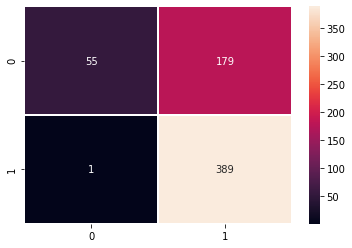

In [40]:
cm = confusion_matrix(test_labels, predictions)
print(cm)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

One thing that can be said for the above model is that from the most basic model perspective, it is already outperforming ANN. The first ANN model had a test accuracy rating of 65%, this one has 70%. However, considerable overfitting is present here as well.

#### Model 2:
More layers

- 3 convolution layers: 32, 64, 128 filters. Maxpooling ONLY after each
- 3 Dense layers: 128 ,64, 2
- batch size of 128
- 20 epochs
- validation split of 0.2

In [41]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation = 'relu', padding='same', input_shape = [150,150,3]),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation = 'relu', padding='same'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation = 'relu', padding='same'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 41472)            

In [42]:
history = model.fit(train_images, train_labels, batch_size = 128, epochs = 20, verbose = 1, validation_split = 0.2)

Epoch 1/20
33/33 [==============================] - 49s 1s/step - loss: 0.3028 - accuracy: 0.9288 - val_loss: 1.2119 - val_accuracy: 0.0029
Epoch 2/20
33/33 [==============================] - 50s 2s/step - loss: 0.1225 - accuracy: 0.9554 - val_loss: 0.4434 - val_accuracy: 0.8276
Epoch 3/20
33/33 [==============================] - 50s 2s/step - loss: 0.0758 - accuracy: 0.9708 - val_loss: 0.3531 - val_accuracy: 0.8784
Epoch 4/20
33/33 [==============================] - 50s 2s/step - loss: 0.0552 - accuracy: 0.9796 - val_loss: 0.8664 - val_accuracy: 0.6983
Epoch 5/20
33/33 [==============================] - 50s 2s/step - loss: 0.0425 - accuracy: 0.9842 - val_loss: 0.6475 - val_accuracy: 0.7739
Epoch 6/20
33/33 [==============================] - 51s 2s/step - loss: 0.0336 - accuracy: 0.9871 - val_loss: 0.7706 - val_accuracy: 0.7577
Epoch 7/20
33/33 [==============================] - 50s 2s/step - loss: 0.0317 - accuracy: 0.9873 - val_loss: 0.4971 - val_accuracy: 0.8602
Epoch 8/20
33/33 [==

In [44]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

Test Score: 4.47135591506958
Test Accuracy: 0.7147436141967773


In [45]:
predictions = model.predict_classes(test_images)
predictions = predictions.reshape(1, -1)[0]

print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))

              precision    recall  f1-score   support

   Normal: 0       1.00      0.24      0.39       234
Pneumonia: 1       0.69      1.00      0.81       390

    accuracy                           0.71       624
   macro avg       0.84      0.62      0.60       624
weighted avg       0.80      0.71      0.65       624



[[ 56 178]
 [  0 390]]


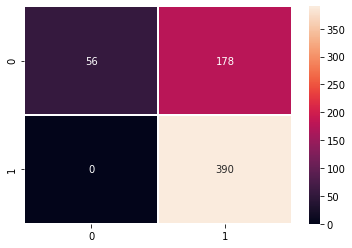

In [46]:
cm = confusion_matrix(test_labels, predictions)
print(cm)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

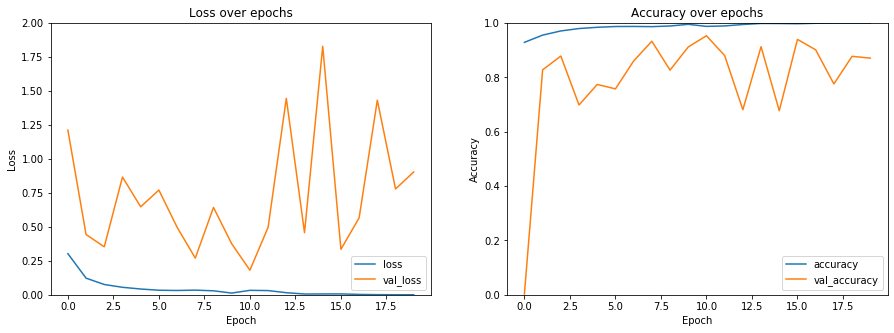

In [47]:
plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(loc='lower right')
plt.title("Loss over epochs")

plt.subplot(122)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.show()

Very slight gains over the last model, not much to be said here, simply that more work needs to be done.

#### Model 3:
Addition of regularization elements to control for overfitting

- 3 convolution layers: 32, 64, 128 filters. Maxpooling ONLY after each
- l1 regularization added to 64 and 128 convolution layer.
- 3 Dense layers: 128 ,64, 2
- 50% dropout layer added after each Dense layer.
- batch size of 128
- 20 epochs
- validation split of 0.2

In [48]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation = 'relu', padding='same', input_shape = [150,150,3]),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l1( l = 0.01)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l1( l = 0.01)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.l1( l = 0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu', kernel_regularizer = tf.keras.regularizers.l1( l = 0.01)),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 41472)            

In [49]:
history = model.fit(train_images, train_labels, batch_size = 128, epochs = 20, verbose = 1, validation_split = 0.2)

Epoch 1/20
33/33 [==============================] - 50s 2s/step - loss: 95.8818 - accuracy: 0.9209 - val_loss: 30.3957 - val_accuracy: 0.0000e+00
Epoch 2/20
33/33 [==============================] - 54s 2s/step - loss: 17.3173 - accuracy: 0.9288 - val_loss: 13.4525 - val_accuracy: 0.0000e+00
Epoch 3/20
33/33 [==============================] - 54s 2s/step - loss: 9.7722 - accuracy: 0.9288 - val_loss: 10.6137 - val_accuracy: 0.0000e+00
Epoch 4/20
33/33 [==============================] - 51s 2s/step - loss: 7.9939 - accuracy: 0.9288 - val_loss: 9.5117 - val_accuracy: 0.0000e+00
Epoch 5/20
33/33 [==============================] - 50s 2s/step - loss: 7.1419 - accuracy: 0.9288 - val_loss: 8.9171 - val_accuracy: 0.0000e+00
Epoch 6/20
33/33 [==============================] - 50s 2s/step - loss: 6.8176 - accuracy: 0.9288 - val_loss: 9.1481 - val_accuracy: 0.0000e+00
Epoch 7/20
33/33 [==============================] - 50s 2s/step - loss: 6.7414 - accuracy: 0.9288 - val_loss: 9.1347 - val_accuracy

Test Score: 7.545849800109863
Test Accuracy: 0.625
-------------------------------------
Classification Report
              precision    recall  f1-score   support

   Normal: 0       0.00      0.00      0.00       234
Pneumonia: 1       0.62      1.00      0.77       390

    accuracy                           0.62       624
   macro avg       0.31      0.50      0.38       624
weighted avg       0.39      0.62      0.48       624

-------------------------------------


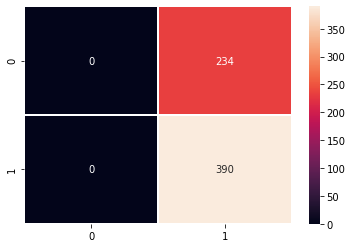

In [50]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

predictions = model.predict_classes(test_images)
predictions = predictions.reshape(1, -1)[0]

print('-------------------------------------')
print('Classification Report')
print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))
print('-------------------------------------')

cm = confusion_matrix(test_labels, predictions)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

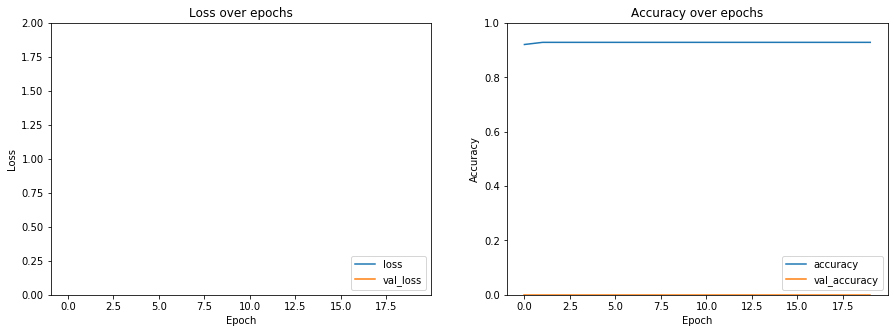

In [51]:
plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(loc='lower right')
plt.title("Loss over epochs")

plt.subplot(122)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.show()

This model is suffering from a considerable amount of loss, which translated to very low test accuracy (65%). There is also evidence of considerable overfitting.

More tuning is needed.

#### Model 4:
l2 regularization 

- 3 convolution layers: 32, 64, 128 filters. Maxpooling ONLY after each
- l2 regularization added to 64 and 128 convolution layer.
- 3 Dense layers: 128 ,64, 2
- L2 regularization added to 128 Dense layer
- 50% dropout layer added after 64 Dense layer
- batch size of 128
- 20 epochs
- validation split of 0.2

In [52]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), activation = 'relu', padding='same', input_shape = [150,150,3]),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64, (3,3), activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(128, (3,3), activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer= 'adam', loss= 'sparse_categorical_crossentropy', metrics= ['accuracy'])

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_18 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_19 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 41472)           

In [53]:
history = model.fit(train_images, train_labels, batch_size = 128, epochs = 20, verbose = 1, validation_split = 0.2)

Epoch 1/20
33/33 [==============================] - 50s 2s/step - loss: 1.6551 - accuracy: 0.9171 - val_loss: 2.8811 - val_accuracy: 0.0000e+00
Epoch 2/20
33/33 [==============================] - 49s 1s/step - loss: 0.5146 - accuracy: 0.9286 - val_loss: 2.1786 - val_accuracy: 0.0000e+00
Epoch 3/20
33/33 [==============================] - 52s 2s/step - loss: 0.3017 - accuracy: 0.9367 - val_loss: 0.9081 - val_accuracy: 0.6063
Epoch 4/20
33/33 [==============================] - 51s 2s/step - loss: 0.2410 - accuracy: 0.9518 - val_loss: 0.6152 - val_accuracy: 0.8161
Epoch 5/20
33/33 [==============================] - 51s 2s/step - loss: 0.2058 - accuracy: 0.9561 - val_loss: 0.5101 - val_accuracy: 0.8333
Epoch 6/20
33/33 [==============================] - 51s 2s/step - loss: 0.1757 - accuracy: 0.9688 - val_loss: 1.3123 - val_accuracy: 0.4473
Epoch 7/20
33/33 [==============================] - 51s 2s/step - loss: 0.1459 - accuracy: 0.9693 - val_loss: 0.5859 - val_accuracy: 0.8056
Epoch 8/20
3

Test Score: 1.5846070051193237
Test Accuracy: 0.6650640964508057
-------------------------------------
Classification Report
              precision    recall  f1-score   support

   Normal: 0       1.00      0.11      0.19       234
Pneumonia: 1       0.65      1.00      0.79       390

    accuracy                           0.67       624
   macro avg       0.83      0.55      0.49       624
weighted avg       0.78      0.67      0.57       624

-------------------------------------


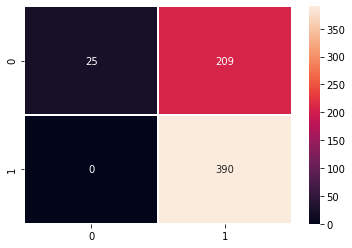

In [54]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

predictions = model.predict_classes(test_images)
predictions = predictions.reshape(1, -1)[0]

print('-------------------------------------')
print('Classification Report')
print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))
print('-------------------------------------')

cm = confusion_matrix(test_labels, predictions)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

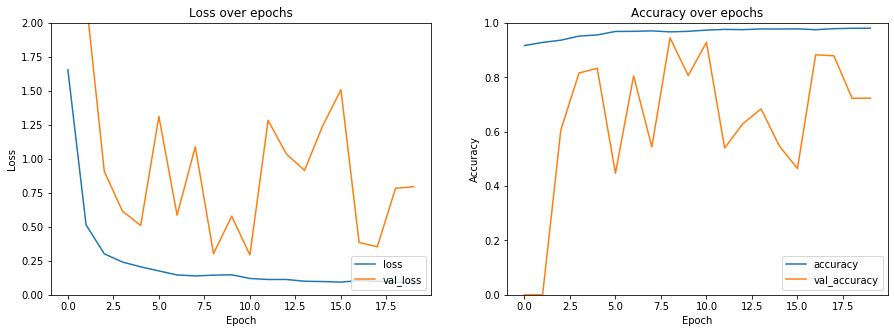

In [55]:
plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(loc='lower right')
plt.title("Loss over epochs")

plt.subplot(122)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.show()

Loss is coming within bounds. Also, test accuracy is coming back up (67%). There is still evidence of overfitting. Also, according to the confusion matrix there is a lot of mislabelling of non-pneumonia images as pneumonia.

Maybe something needs to be done to the images.

### Interlude (kind of)

Overfitting may be coming from the model getting to used to a certain image type. Thus, I will use kera image preprocessing to play with the orientations and shift the images around in order to better train the model.

The method I used is on display below. I did not touch the test set, only the training and validation sets.

In [56]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(train_images)

In [73]:
datagen_val = tf.keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen_val.fit(val_images)

#### Model 5:
First use of new image data

- 3 convolution layers: 32, 64, 128 filters. Maxpooling ONLY after each
- l2 regularization added to 64 and 128 convolution layer.
- 3 Dense layers: 128 ,64, 2
- L2 regularization added to 128 Dense layer
- 50% dropout layer added after 64 Dense layer
- batch size of 128
- 20 epochs
- validation split of 0.2

In [117]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), strides = 1,activation = 'relu', padding='same', input_shape = [150,150,3]),
    keras.layers.MaxPooling2D((2,2), strides = 2),
    keras.layers.Conv2D(64, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D((2,2), strides = 2),
    keras.layers.Conv2D(128, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D((2,2), strides = 2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer= 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_72 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_69 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_73 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_74 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_22 (Flatten)         (None, 41472)           

In [118]:
history = model.fit(datagen.flow(train_images, train_labels, batch_size = 128), epochs = 20, verbose = 1, validation_data = datagen.flow(val_images, val_labels))

Epoch 1/20
41/41 [==============================] - 66s 2s/step - loss: 2.0392 - accuracy: 0.7270 - val_loss: 1.3153 - val_accuracy: 0.5000
Epoch 2/20
41/41 [==============================] - 63s 2s/step - loss: 0.9203 - accuracy: 0.7429 - val_loss: 1.1620 - val_accuracy: 0.5000
Epoch 3/20
41/41 [==============================] - 64s 2s/step - loss: 0.7086 - accuracy: 0.7519 - val_loss: 0.8890 - val_accuracy: 0.6875
Epoch 4/20
41/41 [==============================] - 61s 1s/step - loss: 0.6052 - accuracy: 0.7920 - val_loss: 0.8323 - val_accuracy: 0.7500
Epoch 5/20
41/41 [==============================] - 60s 1s/step - loss: 0.5101 - accuracy: 0.8388 - val_loss: 1.0331 - val_accuracy: 0.5625
Epoch 6/20
41/41 [==============================] - 60s 1s/step - loss: 0.4721 - accuracy: 0.8482 - val_loss: 1.0273 - val_accuracy: 0.5625
Epoch 7/20
41/41 [==============================] - 61s 1s/step - loss: 0.4546 - accuracy: 0.8468 - val_loss: 0.8531 - val_accuracy: 0.8125
Epoch 8/20
41/41 [==

Test Score: 0.4556434452533722
Test Accuracy: 0.8365384340286255
-------------------------------------
Classification Report
              precision    recall  f1-score   support

   Normal: 0       0.89      0.64      0.75       234
Pneumonia: 1       0.82      0.95      0.88       390

    accuracy                           0.84       624
   macro avg       0.85      0.80      0.81       624
weighted avg       0.84      0.84      0.83       624

-------------------------------------


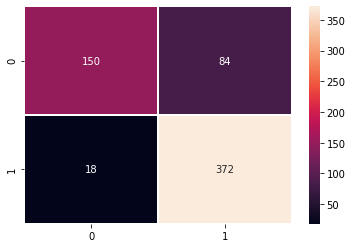

In [119]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

predictions = model.predict_classes(test_images)
predictions = predictions.reshape(1, -1)[0]

print('-------------------------------------')
print('Classification Report')
print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))
print('-------------------------------------')

cm = confusion_matrix(test_labels, predictions)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

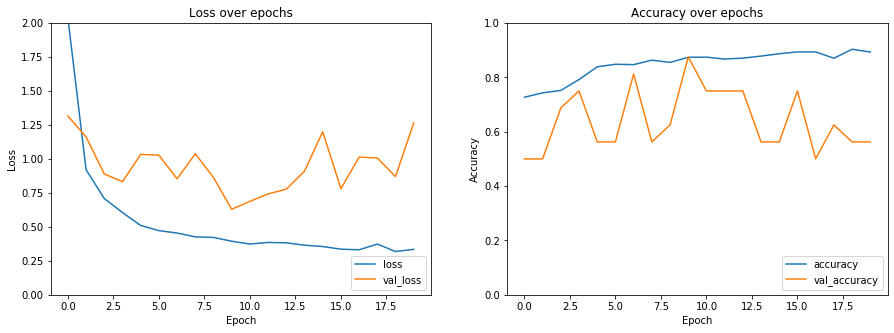

In [120]:
plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(loc='lower right')
plt.title("Loss over epochs")

plt.subplot(122)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.show()

With 84% test accuracy and 89% training accuracy, it seems the problem of overfitting has been solved.

Graphs of loss and accuracy over epochs also seems to be doing quite fine.

However, is it possible to do better than 84%?

### Another modification

I believe if I were to play with the learning rate over time, I could achieve higher accuracy rates.

The next modification I will do to this model is to incorporate a change in learning rate once validation accuracy plateaus.

I will do this with keras callsbacks "ReduceLROnPlateau" method.

In [62]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.0000001)

#### Model 6:
Using Learning Rate modification for the first time.

- 3 convolution layers: 32, 64, 128 filters. Maxpooling ONLY after each
- l2 regularization added to 64 and 128 convolution layer.
- 3 Dense layers: 128 ,64, 2
- L2 regularization added to 128 Dense layer
- 50% dropout layer added after 64 Dense layer
- batch size of 64
- 20 epochs
- validation data used

In [64]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), strides = 1,activation = 'relu', padding='same', input_shape = [150,150,3]),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(64, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Conv2D(128, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer= 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_32 (Conv2D)           (None, 37, 37, 128)       73856     
_________________________________________________________________
max_pooling2d_32 (MaxPooling (None, 18, 18, 128)       0         
_________________________________________________________________
flatten_11 (Flatten)         (None, 41472)           

In [65]:
history = model.fit(datagen.flow(train_images, train_labels, batch_size = 64), epochs = 20, verbose = 1, validation_data = datagen.flow(val_images, val_labels), callbacks=[learning_rate_reduction])

Epoch 1/20
82/82 [==============================] - 62s 756ms/step - loss: 1.3283 - accuracy: 0.7333 - val_loss: 1.0284 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/20
82/82 [==============================] - 68s 825ms/step - loss: 0.6446 - accuracy: 0.7450 - val_loss: 0.7724 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 3/20
82/82 [==============================] - 64s 777ms/step - loss: 0.5390 - accuracy: 0.7803 - val_loss: 0.9944 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 4/20
82/82 [==============================] - ETA: 0s - loss: 0.4631 - accuracy: 0.8273
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
82/82 [==============================] - 64s 783ms/step - loss: 0.4631 - accuracy: 0.8273 - val_loss: 0.7842 - val_accuracy: 0.5625 - lr: 0.0010
Epoch 5/20
82/82 [==============================] - 63s 773ms/step - loss: 0.4114 - accuracy: 0.8595 - val_loss: 0.8822 - val_accuracy: 0.6875 - lr: 3.0000e-04
Epoch 6/20
82/82 [==============================] - 6

Test Score: 0.48219597339630127
Test Accuracy: 0.7868589758872986
-------------------------------------
Classification Report
              precision    recall  f1-score   support

   Normal: 0       0.77      0.62      0.68       234
Pneumonia: 1       0.79      0.89      0.84       390

    accuracy                           0.79       624
   macro avg       0.78      0.75      0.76       624
weighted avg       0.79      0.79      0.78       624

-------------------------------------


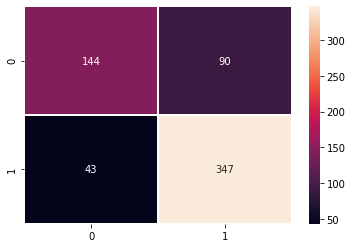

In [66]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

predictions = model.predict_classes(test_images)
predictions = predictions.reshape(1, -1)[0]

print('-------------------------------------')
print('Classification Report')
print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))
print('-------------------------------------')

cm = confusion_matrix(test_labels, predictions)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

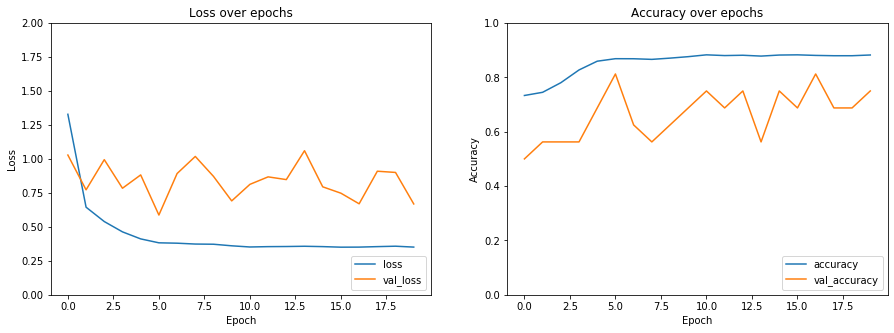

In [67]:
plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(loc='lower right')
plt.title("Loss over epochs")

plt.subplot(122)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.show()

Oddly enough the accuracy went down. Maybe I should add more to this model. I will see what I can do by playing around

#### Model 7:
Adding complexity for better accuracy

- 3 convolution layers: 32, 64, 128 filters. Maxpooling ONLY after each
- l2 regularization added to 64 and 128 convolution layer.
- 20% Dropout added after each maxpooling layer
- Batch normalization added after dropout layer
- 3 Dense layers: 128 ,64, 2
- L2 regularization after 128 Dense layer removed
- 20% dropout layer added after 128 and 64 Dense layer
- batch size of 32
- 30 epochs
- validation data used

In [68]:
model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), strides = 1,activation = 'relu', padding='same', input_shape = [150,150,3]),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D((2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer= 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 37, 37, 64)      

In [69]:
history = model.fit(datagen.flow(train_images, train_labels, batch_size = 32), epochs = 30, verbose = 1, validation_data = datagen.flow(val_images, val_labels), callbacks=[learning_rate_reduction])

Epoch 1/30
163/163 [==============================] - 88s 538ms/step - loss: 2.7915 - accuracy: 0.7272 - val_loss: 15.6361 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 91s 559ms/step - loss: 0.9197 - accuracy: 0.7565 - val_loss: 29.1675 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.6157 - accuracy: 0.8135
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 90s 551ms/step - loss: 0.6157 - accuracy: 0.8135 - val_loss: 31.7314 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 95s 583ms/step - loss: 0.4290 - accuracy: 0.8692 - val_loss: 6.8051 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 97s 594ms/step - loss: 0.3741 - accuracy: 0.8857 - val_loss: 1.4383 - val_accuracy: 0.6250 - lr: 3.0000e-04
Epoch 6/30
163/163 [==============

Test Score: 0.41526418924331665
Test Accuracy: 0.8397436141967773
-------------------------------------
Classification Report
              precision    recall  f1-score   support

   Normal: 0       0.80      0.76      0.78       234
Pneumonia: 1       0.86      0.88      0.87       390

    accuracy                           0.84       624
   macro avg       0.83      0.82      0.83       624
weighted avg       0.84      0.84      0.84       624

-------------------------------------


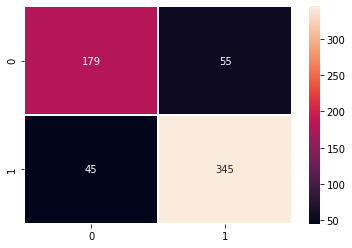

In [70]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

predictions = model.predict_classes(test_images)
predictions = predictions.reshape(1, -1)[0]

print('-------------------------------------')
print('Classification Report')
print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))
print('-------------------------------------')

cm = confusion_matrix(test_labels, predictions)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

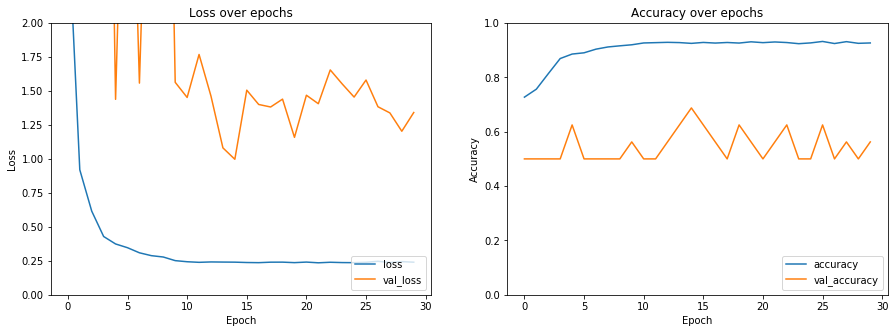

In [71]:
plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(loc='lower right')
plt.title("Loss over epochs")

plt.subplot(122)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.show()

With all the new modifications to the model, there should have been some increase, however it seems there is none. In fact, overfitting is slowly creeping back into the picture with 93% training accuracy and 84% test.

I will continue down this line and attempt to correct by adding a little more

#### Model 8:
Adding more layers to increase accuracy

- learning rate reduction lowered to .000000001 (overkill)
- 4 convolution layers: 32, 64, 128, 256 filters. Maxpooling ONLY after each
- l2 regularization added to 64 and 128 convolution layer.
- 20% Dropout added after each maxpooling layer
- Batch normalization added after dropout layer
- 3 Dense layers: 128 ,64, 2
- L2 regularization after 128 Dense layer removed
- 20% dropout layer added after 128 and 64 Dense layer
- batch size of 32
- 30 epochs
- validation data used

In [76]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000000001)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), strides = 1,activation = 'relu', padding='same', input_shape = [150,150,3]),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding='same'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding='same'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding='same'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding='same'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer= 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_26 (Dropout)         (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
dropout_27 (Dropout)         (None, 38, 38, 64)      

In [77]:
history = model.fit(datagen.flow(train_images, train_labels, batch_size = 32), epochs = 30, verbose = 1, validation_data = datagen_val.flow(val_images, val_labels), callbacks=[learning_rate_reduction])

Epoch 1/30
163/163 [==============================] - 97s 598ms/step - loss: 3.0660 - accuracy: 0.7220 - val_loss: 19.1465 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 99s 608ms/step - loss: 1.6342 - accuracy: 0.7805 - val_loss: 18.4585 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.9672 - accuracy: 0.7878
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 101s 620ms/step - loss: 0.9672 - accuracy: 0.7878 - val_loss: 16.7970 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 99s 610ms/step - loss: 0.6622 - accuracy: 0.8127 - val_loss: 5.2284 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - ETA: 0s - loss: 0.5513 - accuracy: 0.8253
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [==========

Test Score: 0.5566927790641785
Test Accuracy: 0.870192289352417
-------------------------------------
Classification Report
              precision    recall  f1-score   support

   Normal: 0       0.89      0.74      0.81       234
Pneumonia: 1       0.86      0.95      0.90       390

    accuracy                           0.87       624
   macro avg       0.88      0.84      0.86       624
weighted avg       0.87      0.87      0.87       624

-------------------------------------


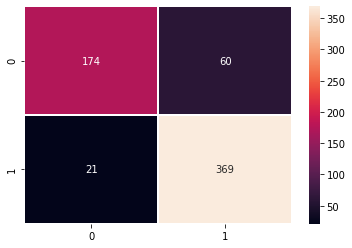

In [78]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

predictions = model.predict_classes(test_images)
predictions = predictions.reshape(1, -1)[0]

print('-------------------------------------')
print('Classification Report')
print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))
print('-------------------------------------')

cm = confusion_matrix(test_labels, predictions)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

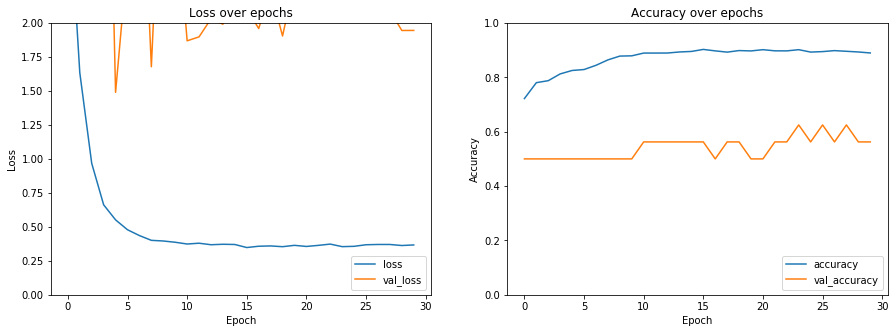

In [80]:
plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(loc='lower right')
plt.title("Loss over epochs")

plt.subplot(122)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.show()

More accuracy has been achieved! 89% training accuracy and 87% test accuracy.

However, Validation and training accuracy seems to be slowly moving away from each other. I want to try to correct this.

#### Model 9:
Correcting for validation and training accuracy with more complexity

- learning rate reduction lowered to .000000001 (overkill)
- 4 convolution layers: 32, 64, 128, 256 filters. Maxpooling ONLY after each
- Maxpooling layers now include a stride of 2 and "same" padding
- l2 regularization added to 64 and 128 convolution layer.
- 20% Dropout added after each maxpooling layer
- Batch normalization added after dropout layer
- 4 Dense layers: 128 ,64, 32, 2
- L2 regularization after 128 Dense layer removed
- 20% dropout layer added after 128 and 64 Dense layer
- batch size of 32
- 30 epochs
- validation data used

In [84]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000000001)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), strides = 1,activation = 'relu', padding='same', input_shape = [150,150,3]),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding= 'same'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l1( l = 0.01)),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding= 'same'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l1( l = 0.01)),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding= 'same'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l1( l = 0.01)),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding= 'same'),
    keras.layers.Dropout(0.2),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer= 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
dropout_43 (Dropout)         (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_22 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_56 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
dropout_44 (Dropout)         (None, 38, 38, 64)      

In [85]:
history = model.fit(datagen.flow(train_images, train_labels, batch_size = 32), epochs = 30, verbose = 1, validation_data = datagen_val.flow(val_images, val_labels), callbacks=[learning_rate_reduction])

Epoch 1/30
163/163 [==============================] - 98s 600ms/step - loss: 20.8943 - accuracy: 0.7540 - val_loss: 6.4392 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 98s 602ms/step - loss: 3.7327 - accuracy: 0.8129 - val_loss: 5.8073 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 2.6902 - accuracy: 0.8315
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 97s 598ms/step - loss: 2.6902 - accuracy: 0.8315 - val_loss: 8.4445 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 99s 607ms/step - loss: 1.2680 - accuracy: 0.8397 - val_loss: 3.6602 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - ETA: 0s - loss: 0.9412 - accuracy: 0.8669
Epoch 00005: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
163/163 [=============

Test Score: 0.5909795761108398
Test Accuracy: 0.7884615659713745
-------------------------------------
Classification Report
              precision    recall  f1-score   support

   Normal: 0       0.90      0.49      0.63       234
Pneumonia: 1       0.76      0.97      0.85       390

    accuracy                           0.79       624
   macro avg       0.83      0.73      0.74       624
weighted avg       0.81      0.79      0.77       624

-------------------------------------


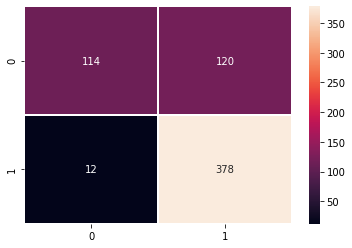

In [86]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

predictions = model.predict_classes(test_images)
predictions = predictions.reshape(1, -1)[0]

print('-------------------------------------')
print('Classification Report')
print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))
print('-------------------------------------')

cm = confusion_matrix(test_labels, predictions)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

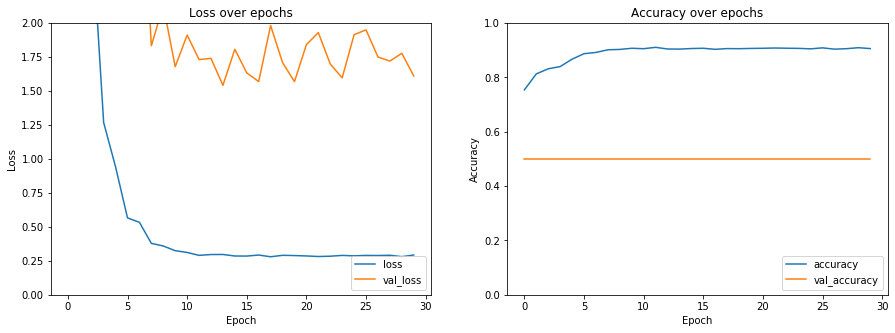

In [87]:
plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(loc='lower right')
plt.title("Loss over epochs")

plt.subplot(122)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.show()

It seems that this is the critical mass of complexity. The model is performing worse now with 79%  accuracy. Also, nothing has been achieved on the accuracy and loss side. Validation didn't change whatsoever in the accuracy graph as well.

#### Model 10:
Moving back and simplifying the model.

- learning rate reduction lowered to .000000001
- 3 convolution layers: 32, 64, 128 filters. Maxpooling ONLY after each
- Maxpooling layers now include a stride of 2 and "same" padding
- l2 regularization added to 64 and 128 convolution layer.
- 4 Dense layers: 128 ,64, 32, 2
- 20% dropout layer added after 128 and 64 Dense layer
- batch size of 32
- 30 epochs
- validation data used

In [90]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000000001)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), strides = 1,activation = 'relu', padding='same', input_shape = [150,150,3]),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding= 'same'),
    keras.layers.Conv2D(64, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding= 'same'),
    keras.layers.Conv2D(128, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding= 'same'),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer= 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_66 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_67 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_64 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 38, 38, 128)       73856     
_________________________________________________________________
max_pooling2d_65 (MaxPooling (None, 19, 19, 128)       0         
_________________________________________________________________
flatten_20 (Flatten)         (None, 46208)           

In [91]:
history = model.fit(datagen.flow(train_images, train_labels, batch_size = 32), epochs = 30, verbose = 1, validation_data = datagen_val.flow(val_images, val_labels), callbacks=[learning_rate_reduction])

Epoch 1/30
163/163 [==============================] - 65s 400ms/step - loss: 0.8995 - accuracy: 0.7264 - val_loss: 0.8162 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 65s 396ms/step - loss: 0.5486 - accuracy: 0.7441 - val_loss: 0.7475 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - 64s 392ms/step - loss: 0.4594 - accuracy: 0.7674 - val_loss: 0.7917 - val_accuracy: 0.6875 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 64s 393ms/step - loss: 0.4359 - accuracy: 0.7912 - val_loss: 0.8354 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 5/30
163/163 [==============================] - ETA: 0s - loss: 0.4073 - accuracy: 0.8202
Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 63s 387ms/step - loss: 0.4073 - accuracy: 0.8202 - val_loss: 1.0627 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 6/30
163/163 [=========================

Test Score: 0.4111710488796234
Test Accuracy: 0.8108974099159241
-------------------------------------
Classification Report
              precision    recall  f1-score   support

   Normal: 0       0.81      0.65      0.72       234
Pneumonia: 1       0.81      0.91      0.86       390

    accuracy                           0.81       624
   macro avg       0.81      0.78      0.79       624
weighted avg       0.81      0.81      0.81       624

-------------------------------------


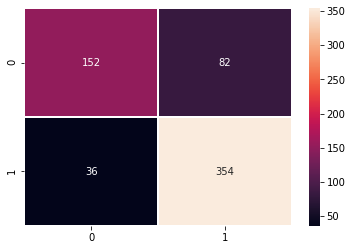

In [92]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

predictions = model.predict_classes(test_images)
predictions = predictions.reshape(1, -1)[0]

print('-------------------------------------')
print('Classification Report')
print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))
print('-------------------------------------')

cm = confusion_matrix(test_labels, predictions)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

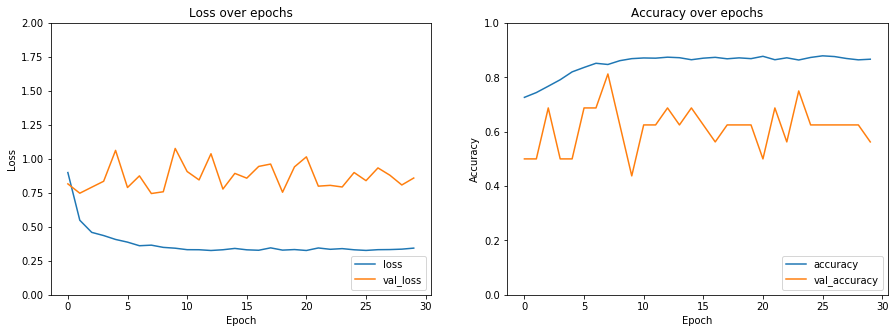

In [93]:
plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(loc='lower right')
plt.title("Loss over epochs")

plt.subplot(122)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.show()

We've regained some of the accuracy score with 81%. Graphs are also looking better. However, it is possible that this model became slightly too simple and we can get some of the accuracy score back.

#### FINAL model:
Synthesizing lessons learning from over-complexity and over-simplicity

- learning rate reduction lowered to .000001
- 3 convolution layers: 32, 64, 128 filters. Maxpooling ONLY after each
- Maxpooling layers now include a stride of 2 and "same" padding
- Batch-normalization re-added
- l2 regularization added to 64 and 128 convolution layer.
- 3 Dense layers: 128 ,64, 2
- 20% dropout layer added after 128 and 64 Dense layer
- batch size of 32
- 30 epochs
- validation data used

In [94]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

model = keras.models.Sequential([
    keras.layers.Conv2D(32, (3,3), strides = 1,activation = 'relu', padding='same', input_shape = [150,150,3]),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding= 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(64, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding= 'same'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(128, (3,3), strides = 1 ,activation = 'relu', padding='same', kernel_regularizer = tf.keras.regularizers.l2( l = 0.01)),
    keras.layers.MaxPooling2D((2,2), strides = 2, padding= 'same'),
    keras.layers.BatchNormalization(),    
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(2, activation='softmax')
])

model.summary()

model.compile(optimizer= 'adam', loss = 'sparse_categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_69 (Conv2D)           (None, 150, 150, 32)      896       
_________________________________________________________________
max_pooling2d_66 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 75, 75, 32)        128       
_________________________________________________________________
conv2d_70 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_67 (MaxPooling (None, 38, 38, 64)        0         
_________________________________________________________________
batch_normalization_31 (Batc (None, 38, 38, 64)        256       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 38, 38, 128)     

In [95]:
history = model.fit(datagen.flow(train_images, train_labels, batch_size = 32), epochs = 30, verbose = 1, validation_data = datagen_val.flow(val_images, val_labels), callbacks=[learning_rate_reduction])

Epoch 1/30
163/163 [==============================] - 75s 462ms/step - loss: 1.8307 - accuracy: 0.7951 - val_loss: 19.9455 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/30
163/163 [==============================] - 76s 468ms/step - loss: 0.9972 - accuracy: 0.8656 - val_loss: 11.9358 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/30
163/163 [==============================] - ETA: 0s - loss: 0.6570 - accuracy: 0.8867
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 [==============================] - 77s 470ms/step - loss: 0.6570 - accuracy: 0.8867 - val_loss: 5.4171 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/30
163/163 [==============================] - 75s 463ms/step - loss: 0.4779 - accuracy: 0.9093 - val_loss: 3.9954 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/30
163/163 [==============================] - 75s 462ms/step - loss: 0.3972 - accuracy: 0.9250 - val_loss: 0.7895 - val_accuracy: 0.8125 - lr: 3.0000e-04
Epoch 6/30
163/163 [===============

Test Score: 0.43291428685188293
Test Accuracy: 0.8862179517745972
-------------------------------------
Classification Report
              precision    recall  f1-score   support

   Normal: 0       0.97      0.72      0.83       234
Pneumonia: 1       0.86      0.98      0.92       390

    accuracy                           0.89       624
   macro avg       0.91      0.85      0.87       624
weighted avg       0.90      0.89      0.88       624

-------------------------------------


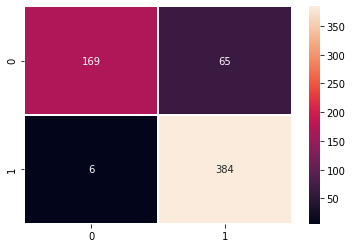

In [96]:
score = model.evaluate(test_images, test_labels, verbose=0)
print('Test Score: {}'.format(score[0]))
print('Test Accuracy: {}'.format(score[1]))

predictions = model.predict_classes(test_images)
predictions = predictions.reshape(1, -1)[0]

print('-------------------------------------')
print('Classification Report')
print(classification_report(test_labels, predictions, target_names = ['Normal: 0', 'Pneumonia: 1']))
print('-------------------------------------')

cm = confusion_matrix(test_labels, predictions)

sns.heatmap(cm, linewidth= 1, annot= True, fmt= '')

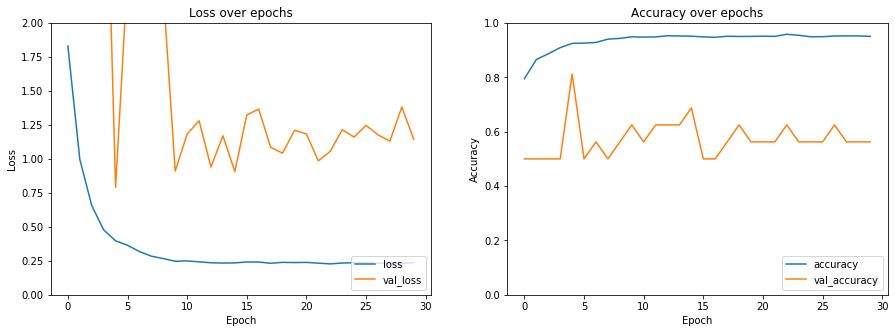

In [97]:
plt.figure(figsize=(15,5))
plt.subplot(121)

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0,2])
plt.legend(loc='lower right')
plt.title("Loss over epochs")

plt.subplot(122)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0,1])
plt.legend(loc='lower right')
plt.title('Accuracy over epochs')

plt.show()

Finally, with this final model, things are looking much better.

I have gotten the best accuracy score up till now with 89%

In addition, loss and accuracy graphs aren't great, but they are still looking much better than before.

Overfitting has also been avoided.

# Conclusion

The above dataset consisted of chest x-rays of hospital patients who either: 1) had pneumonia or 2) did not have any lung afflictions whatsoever.

The goal of this project was to see if I could train a deep learning model to detect whether images belonged to the pneumonia or non-pneumonia group.

From the final model presented in this project, the model was able to determine with 89% accuracy (average fo 91% precision and 87% recall) the correct group of the x-ray images. This puts the model in above-average performance. However, as medical data science is a field which is very unforgiving to false positives and false negatives, there is still a lot that could be done. This includes:

- running pre-built models such as the ResNet series or the VGG16/19 series of computer vision models to compare performance
- Modifying the imagedatagenerator to slightly change image variation
- fine-tuning the complexity of each of the models.

I believe this project was able to come up with the beginnings of a true data science product. However, in thinking about what kind of client would use this model (physicians and radiologists), I do believe that the cutoff point that would put me in consideration for actual real-world use would be around 95-96% accuracy.

In the current state, were the model to be used in an actual radiologist's lab, there would still be significant need for an attending physician to double-check each x-ray to minimize the occurence of false positives/negatives

However, were the stakes lower for something such as identifying bronchitis or other non-life threatening issues, I believe that we would be fairly within bounds. If a family physician were to take advantage of these kinds of models for less serious sicknesses, a serious amount of work time could be saved in staring at each and every x-ray of a patient. Other cases which a similar model to this one could be used are:

- identifying types of bone fractures
- identifying odd bone structures (for chiropractic use)
- helping to identifying objects that may be inside of people (pacemakers, stitches, etc)
- helping to identify ossification of muscle tissue for serious muscle inflictions

In other words, for something like pneumonia, I don't believe the model is yet up to scratch, however with transfer learning or simply running another image set through the same code shown above, I believe a workable model for less-serious afflictions could be made.